Code adapted from https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/notebooks/regression/bbp_hetero.ipynb

By JavierAntoran (https://github.com/JavierAntoran)

In [1]:
import os # Avoids the OpenMP error when used in conjunction with the below command 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

import arviz as az

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device = ",device)

if device.type == "cpu":
    cuda = False
else:
    cuda = True
    
    
import sys
sys.path.append('../../duq/')
  
# Importing the Bayesian LR module
import pre
import post
import sgld as SG
import pandas as pd
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

Device =  cpu
Device =  cpu


In [2]:
def to_variable(var=(), cuda=False, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [3]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


#def get_kl_divergence(weights, prior, varpost):
#    prior_loglik = prior.loglik(weights)
#    
#    varpost_loglik = varpost.loglik(weights)
#    varpost_lik = varpost_loglik.exp()
#    
#    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [4]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [13]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, no_units, gaussian(0,1))
        self.layer3 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        #self.layer3 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        #self.activation = torch.sin
        self.log_noise = nn.Parameter(torch.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        # First hidden layer
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        # Second hidden layer
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)

        # Output layer
        x, KL_loss = self.layer3(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [14]:
class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        #self.network.cuda()
        
        #self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate) 
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=False)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

# Define true function and training/test data 

In [15]:
def f(x):
    """ Function to plot a damped sinusoid """ 
    A = 2         # Initial amplitude
    lamb = 0.2    # Decay constant
    w = 2         # Angular frequency
    phi = 0       # Phase angle at t=0
    flipped = False # Whether to flip the x axis or not
    if torch.is_tensor(x):
        res = A*torch.exp(-lamb*x)*(torch.cos(w*x+phi) + torch.sin(w*x + phi))
        if flipped:
            res = res.numpy()
            res = np.flip(res).copy()
            res = torch.Tensor(res)
        return res
    else:
        res = A*np.exp(-lamb*x)*(np.cos(w*x+phi) + np.sin(w*x + phi))
        if flipped: res = np.flip(res)
        return res

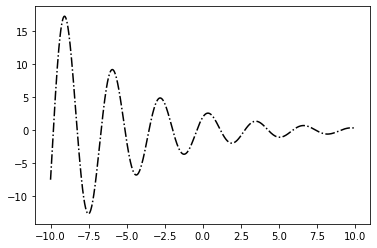

In [16]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-10,10,1000)
Y = f(X)

plt.plot(X,Y,'k-.')

df = pd.DataFrame({"X":X,"Y":Y})

x_cols=[0]
y_cols=[1]
component = 0 # Sort by the x component 
cutoff_percentile = (0.5,0.5)
val_split = 0.2
component_name = "Y"

df, data_mean, data_std = pre.process_df_euclid(df=df, x_cols=x_cols)

y_mean = data_mean[y_cols].values
x_mean = data_mean[x_cols].values
y_std = data_std[y_cols].values
x_std = data_std[x_cols].values

TRAIN, VAL, TEST = pre.split_data(df, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

In [51]:
num_epochs = 2000
batch_size = len(x_train)
num_units = 300
lr = 5e-4

In [52]:
import time

start = time.time()

net = BBP_Homoscedastic_Model_Wrapper(input_dim = 1,
                                      output_dim = 1,
                                      no_units = num_units,
                                      learn_rate = lr,
                                      batch_size = batch_size,
                                      no_batches = 1,
                                      init_log_noise = 0)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net = None
best_loss = float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i], net.network.log_noise.exp().cpu().data.numpy()))

        #samples = []
        #for i in range(100):
        #    preds = net.network.forward(torch.linspace(-3, 3, 200))[0]
        #    samples.append(preds.cpu().data.numpy()[:, 0])
        
        
end = time.time()
print(f"Time taken: {end-start}")

Epoch:     1/ 2000, Fit loss =   79.523, KL loss = 102954.000, noise =  1.000
Epoch:   101/ 2000, Fit loss =  234.216, KL loss = 101953.469, noise =  1.035
Epoch:   201/ 2000, Fit loss =   96.126, KL loss = 100952.242, noise =  1.064
Epoch:   301/ 2000, Fit loss =  124.530, KL loss = 99841.391, noise =  1.075
Epoch:   401/ 2000, Fit loss =   99.311, KL loss = 98628.383, noise =  1.079
Epoch:   501/ 2000, Fit loss =   51.031, KL loss = 97329.242, noise =  1.077
Epoch:   601/ 2000, Fit loss =  137.479, KL loss = 95946.734, noise =  1.068
Epoch:   701/ 2000, Fit loss =   45.763, KL loss = 94497.180, noise =  1.053
Epoch:   801/ 2000, Fit loss =   52.023, KL loss = 92979.836, noise =  1.034
Epoch:   901/ 2000, Fit loss =   77.632, KL loss = 91405.750, noise =  1.011
Epoch:  1001/ 2000, Fit loss =   37.677, KL loss = 89780.656, noise =  0.987
Epoch:  1101/ 2000, Fit loss =   63.699, KL loss = 88105.180, noise =  0.957
Epoch:  1201/ 2000, Fit loss =   53.227, KL loss = 86389.258, noise =  0.

In [53]:
#x_test, y_test = next(iter(test_loader))
def generate_samples(X, y_mean, y_std, num_tests):
    samples = []
    for i in range(num_tests):
        preds = best_net.cpu().forward(X)[0].detach().numpy()
        samples.append(preds)    
    
    samples = np.array(samples)
    samples = pre.unnormalise(samples, y_mean, y_std)

    means = np.zeros((samples.shape[2], samples.shape[1])) # means of shape (num_dependent_vars, num_datapoints)
    stds = np.zeros((samples.shape[2], samples.shape[1])) # means of shape (num_dependent_vars, num_datapoints)

    for i in range(samples.shape[2]):   # Looping over each dependent var
        for j in range(samples.shape[1]): # Looping over each datapoint
            means[i, j] = samples[:, j, i].mean()
            stds[i, j] = samples[:, j, i].std()
    
    samples = np.moveaxis(samples, 2, 0)
    return samples, means, stds

def run_sampling(X, Y, num_tests):
    samples, means, stds= generate_samples(X, y_mean, y_std, num_tests) 

    samples = np.squeeze(samples)

    Y_np = pre.unnormalise(Y.squeeze().numpy(), y_mean, y_std)
    return samples, means, stds, Y_np

num_tests=500

#samples = generate_samples(torch.Tensor(df["X"]).unsqueeze(1), y_mean, y_std, num_tests)
samples_full, means_full, stds_full, y_train_np_full = run_sampling(torch.Tensor(df["X"]).unsqueeze(1), torch.Tensor(df["Y"]).unsqueeze(1), num_tests)
means_full_, stds_full_, x_full_ = post.sort_data([means_full.squeeze(), stds_full.squeeze(), df["X"]], sortby=2)

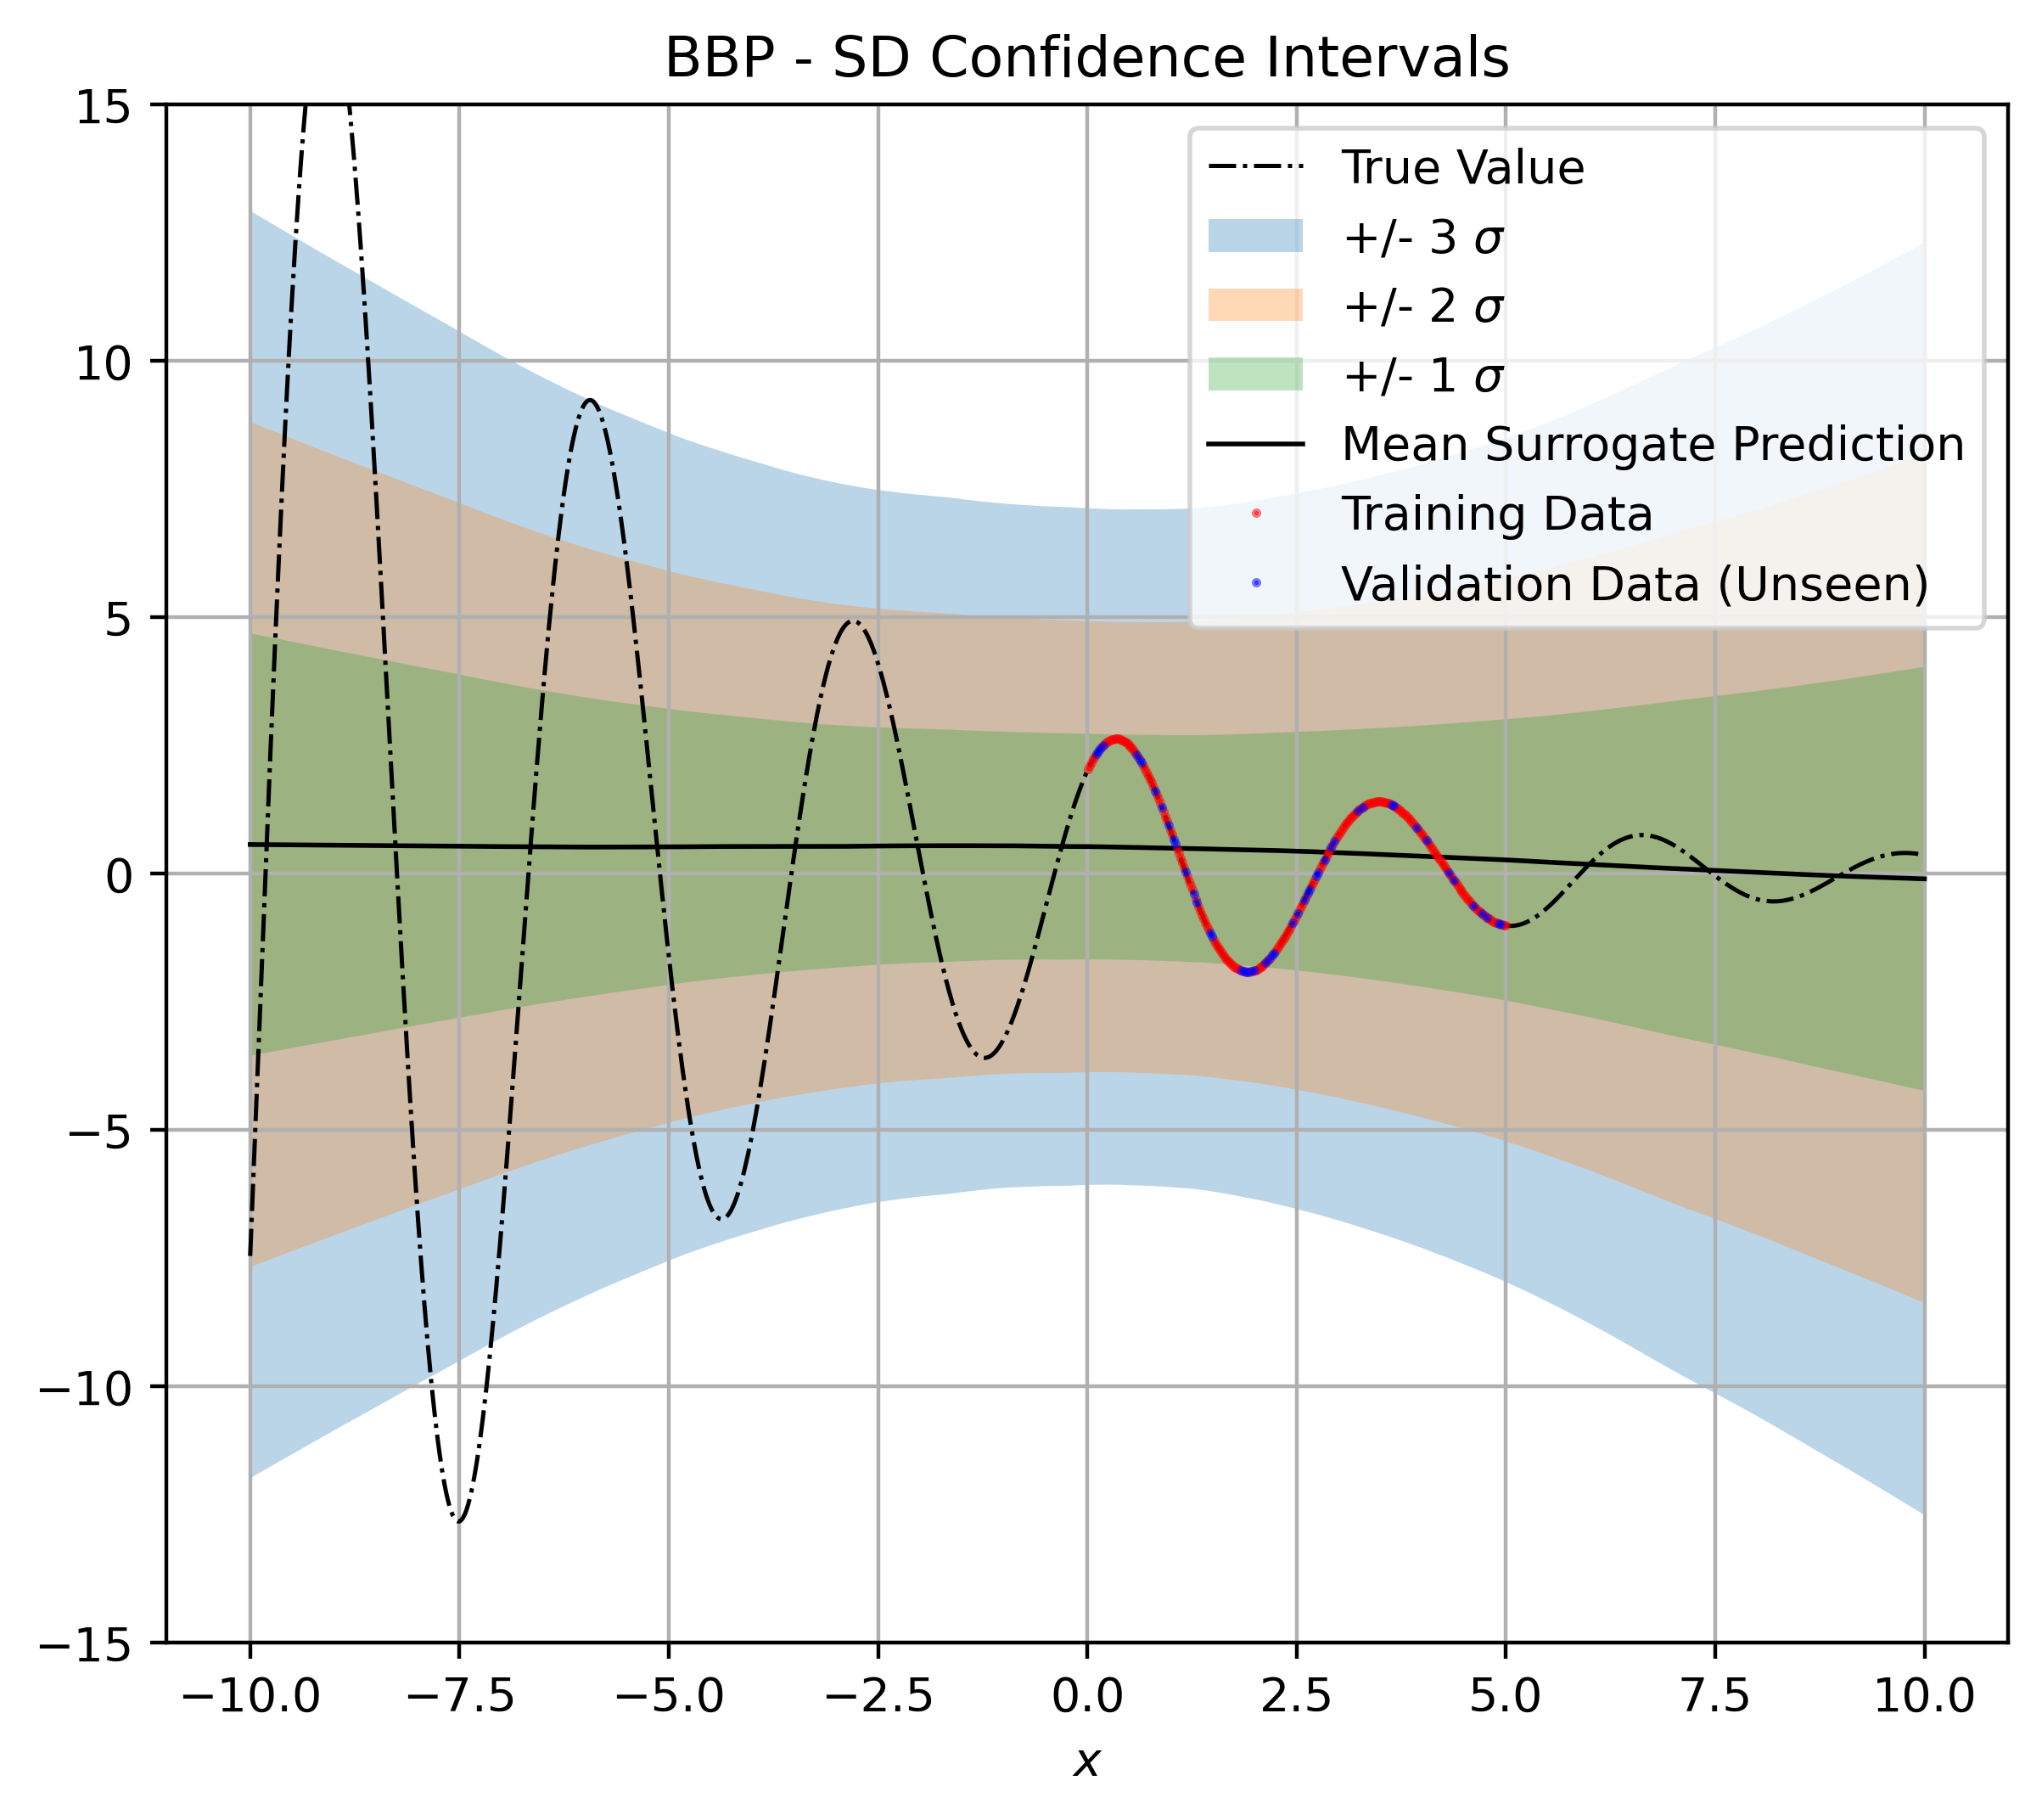

In [63]:

plt.figure(figsize=(7,6), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.fill_between(X, means_full_.ravel() + 3*stds_full_.flatten(), means_full_.ravel() - 3*stds_full_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 2*stds_full_.flatten(), means_full_.ravel() - 2*stds_full_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 1*stds_full_.flatten(), means_full_.ravel() - 1*stds_full_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
#plt.plot(X[test_indices], Y[test_indices], 'oy', alpha=0.5, markersize=3, label="Test Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('BBP - SD Confidence Intervals')
plt.show()

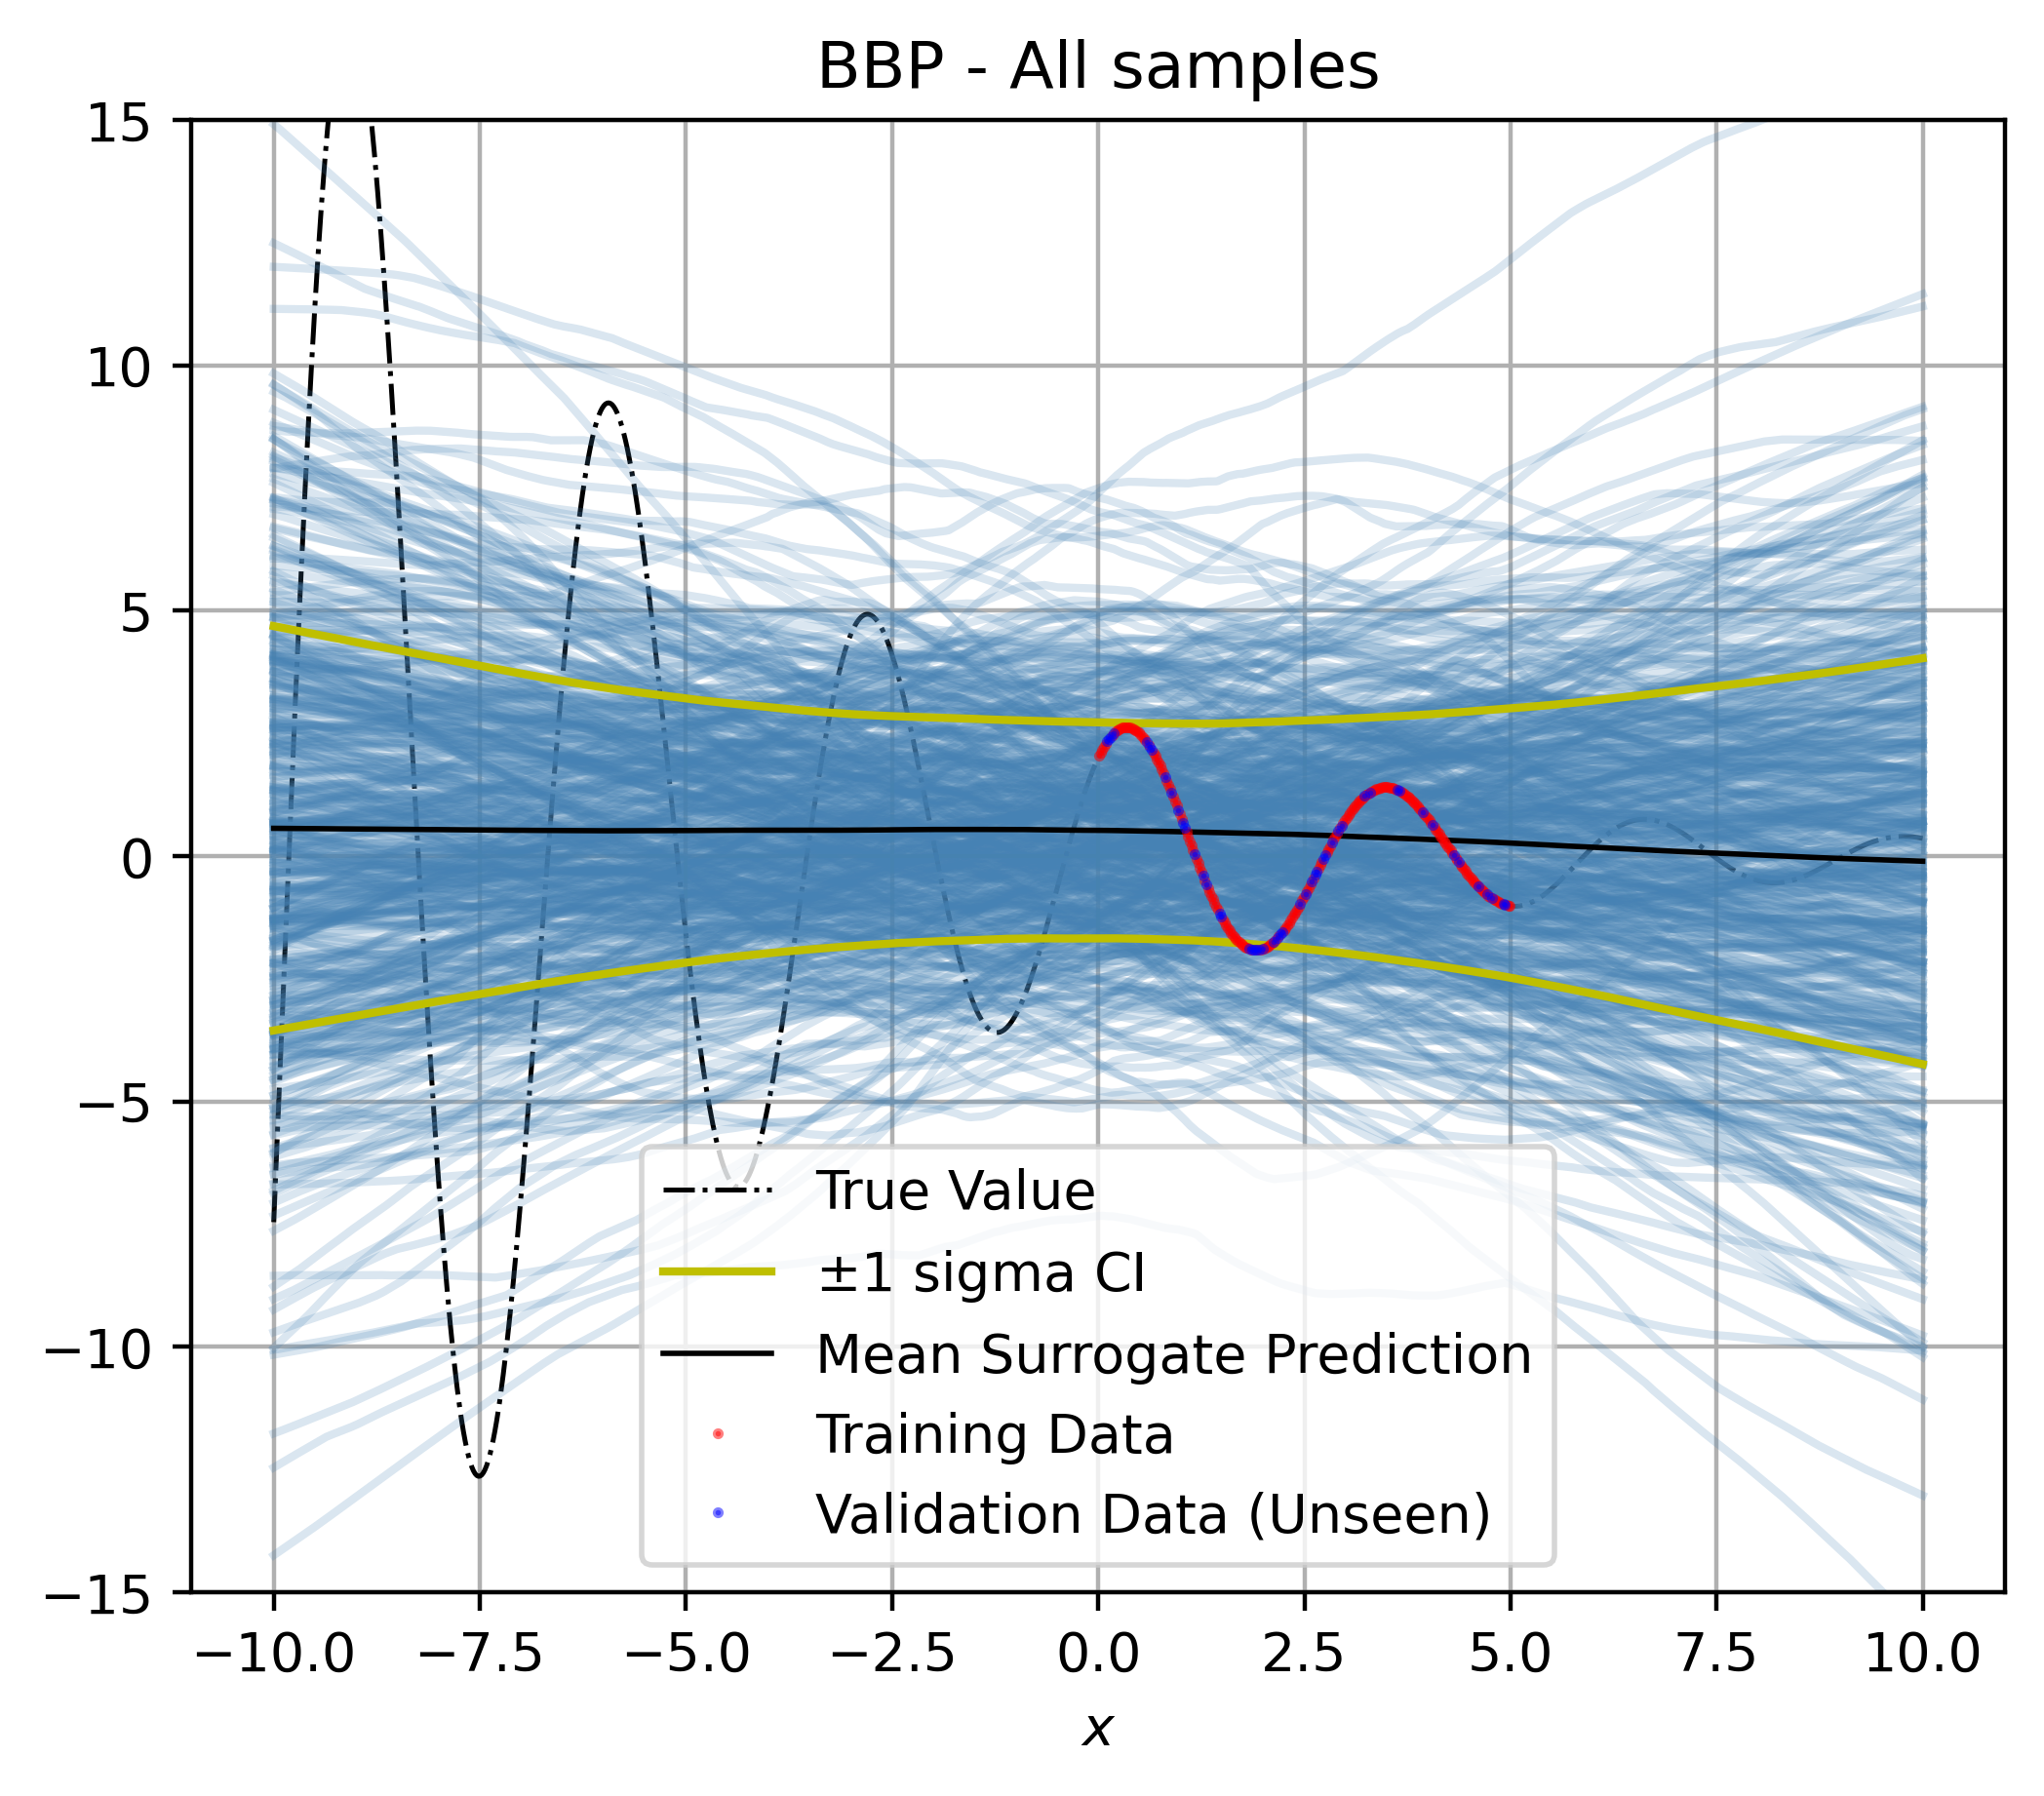

In [64]:
plt.figure(figsize=(6,5), dpi=400)
plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.plot(X, samples_full[:].T,'steelblue',alpha=0.2)
plt.plot(X, means_full_.ravel() + 1*stds_full_.flatten(),'y',label="$\pm$1 sigma CI")
plt.plot(X, means_full_.ravel() - 1*stds_full_.flatten(),'y')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('BBP - All samples')
plt.show()